# Modeling

In [41]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [42]:
df_train = pickle.load(open('df_train_prep.p', 'rb'))
df_test = pickle.load(open('df_test_prep.p', 'rb'))

In [43]:
#instantiate feature matrix and target vector for train set
features_train = df_train.drop("IsBadBuy", axis=1)
target_train = df_train.loc[:, "IsBadBuy"]

In [44]:
#instantiate feature matrix and target vector for test set
features_test = df_test.drop("IsBadBuy", axis=1)
target_test = df_test.loc[:, "IsBadBuy"]

In [45]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58373 entries, 0 to 58372
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Auction                            58373 non-null  category
 1   VehicleAge                         58373 non-null  int64   
 2   Make                               58373 non-null  category
 3   Trim                               58373 non-null  category
 4   Color                              58373 non-null  category
 5   Transmission                       58373 non-null  category
 6   WheelType                          58373 non-null  category
 7   VehOdo                             58373 non-null  int64   
 8   Nationality                        58373 non-null  category
 9   Size                               58373 non-null  category
 10  TopThreeAmericanName               58373 non-null  category
 11  MMRAcquisitionAuctionAveragePrice  58373 

In [46]:
# baseline model: randomly predicting the same number of cases in each class
model_dummy = DummyClassifier(strategy='uniform', random_state=42)

cross_val_score(estimator=model_dummy,
                X=features_train, 
                y=target_train, 
                cv=3, 
                scoring='f1').mean()

0.19580426673003526

In [47]:
features_train.select_dtypes('category').nunique()

Auction                   3
Make                     33
Trim                    133
Color                    16
Transmission              2
WheelType                 3
Nationality               4
Size                     12
TopThreeAmericanName      4
BYRNO                    72
VNST                     37
IsOnlineSale              2
dtype: int64

In [48]:
features_train.loc[:, 'Transmission'].unique()

['AUTO', 'MANUAL']
Categories (2, object): ['AUTO', 'MANUAL']

In [49]:
# dummy coding
features_train.loc[:, 'Transmission'] = features_train.loc[:, 'Transmission'].replace({'AUTO':0, 'MANUAL':1})
features_train.loc[:, 'Transmission'] = features_train.loc[:, 'Transmission'].astype('category')

features_test.loc[:, 'Transmission'] = features_test.loc[:, 'Transmission'].replace({'AUTO':0, 'MANUAL':1})
features_test.loc[:, 'Transmission'] = features_test.loc[:, 'Transmission'].astype('category')

In [50]:
features_train.select_dtypes('category').columns

Index(['Auction', 'Make', 'Trim', 'Color', 'Transmission', 'WheelType',
       'Nationality', 'Size', 'TopThreeAmericanName', 'BYRNO', 'VNST',
       'IsOnlineSale'],
      dtype='object')

In [51]:
ohe_cols = ['Auction', 
            'Make',
            'Trim',
            'Color', 
            'WheelType',
            'Nationality', 
            'Size', 
            'TopThreeAmericanName', 
            'BYRNO', 
            'VNST']

In [52]:
features_train.select_dtypes('number').columns

Index(['VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost', 'PurchMonth',
       'PurchYear'],
      dtype='object')

In [53]:
num_cols = ['VehicleAge', 
            'VehOdo', 
            'MMRAcquisitionAuctionAveragePrice',
            'MMRAcquisitionAuctionCleanPrice', 
            'MMRAcquisitionRetailAveragePrice',
            'MMRAcquisitonRetailCleanPrice', 
            'MMRCurrentAuctionAveragePrice',
            'MMRCurrentAuctionCleanPrice', 
            'MMRCurrentRetailAveragePrice',
            'MMRCurrentRetailCleanPrice', 
            'VehBCost', 
            'WarrantyCost', 
            'PurchMonth',
            'PurchYear']

In [54]:
num_cols = features_train.select_dtypes('category').columns

In [55]:
# one-hot encoding categorial columns and standardising mmr colums to handle high correlations
col_transformer = ColumnTransformer(transformers=[("OHE", OneHotEncoder(handle_unknown="ignore"), ohe_cols)],
                                    remainder="passthrough",
                                    sparse_threshold=0)

scaler = StandardScaler()

In [57]:
# baseline model
from sklearn.linear_model import LogisticRegression

baseline_lr = LogisticRegression(max_iter=1e4)

pipe_base = Pipeline([("col_encoder", col_transformer),
                      ("scaler", scaler),
                      ("model", baseline_lr)])

pipe_base.fit(features_train, target_train)

cv_results = cross_validate(estimator=pipe_base, X=features_train, y=target_train, cv=3, scoring=['precision', 'recall', 'f1'])

In [65]:
cv_results

{'fit_time': array([3.10000014, 3.50400066, 3.38900042]),
 'score_time': array([0.10099983, 0.0999999 , 0.10099983]),
 'test_precision': array([0.34782609, 0.35135135, 0.36507937]),
 'test_recall': array([0.00995851, 0.00539419, 0.00954753]),
 'test_f1': array([0.01936265, 0.01062526, 0.01860841])}

In [80]:
print('precision: ', list(cv_results.values())[2].mean())
print('recall: ', list(cv_results.values())[3].mean())
print('f1: ', list(cv_results.values())[4].mean())

precision:  0.35475226779574603
recall:  0.008300075730303662
f1:  0.016198771960864566


In [17]:
# feature engineering (to be done)

In [81]:
# dimensionality reduction
MMR_cols = ['MMRAcquisitionAuctionAveragePrice', 
            'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice', 
            'MMRCurrentAuctionAveragePrice', 
            'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice', 
            'MMRCurrentRetailCleanPrice']

In [82]:
pca_col_transformer = ColumnTransformer(transformers=[("OHE", OneHotEncoder(handle_unknown="ignore"), ohe_cols),
                                                      
                                                      ("PCA_MMR", PCA(n_components=1, random_state=42), MMR_cols)],
                                        remainder="passthrough",
                                        sparse_threshold=0)
                                         
base_pca_pipe = Pipeline([("col_encoder", pca_col_transformer),
                          ("scaler", scaler),
                          ("pca", PCA(n_components=0.95, random_state=42)),
                          ("model", baseline_lr)])
                          
base_pca_pipe.fit(features_train, target_train)

cross_validate(estimator=pipe_base, X=features_train, y=target_train, cv=3, scoring=['precision', 'recall', 'f1'])

{'fit_time': array([3.14200044, 3.58299994, 3.454     ]),
 'score_time': array([0.10599971, 0.102     , 0.10100007]),
 'test_precision': array([0.34782609, 0.35135135, 0.36507937]),
 'test_recall': array([0.00995851, 0.00539419, 0.00954753]),
 'test_f1': array([0.01936265, 0.01062526, 0.01860841])}

In [84]:
print('precision: ', list(cv_results.values())[2].mean())
print('recall: ', list(cv_results.values())[3].mean())
print('f1: ', list(cv_results.values())[4].mean())

precision:  0.35475226779574603
recall:  0.008300075730303662
f1:  0.016198771960864566


In [85]:
# feature selection
result = permutation_importance(base_pca_pipe, features_train, target_train, random_state=42)
sorted_idx = result.importances_mean.argsort()

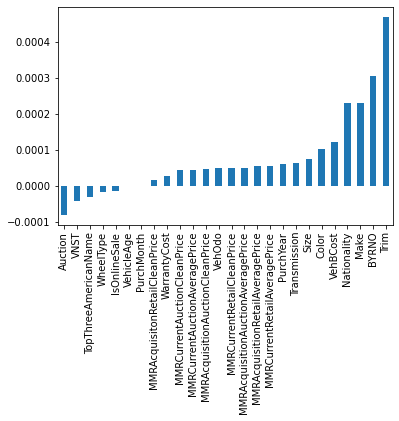

In [21]:
fig, ax = plt.subplots()
pd.Series(result.importances_mean[sorted_idx].T,
          index=features_train.columns[sorted_idx]).plot.bar(ax=ax);

In [86]:
features_train.columns[sorted_idx][:8]

Index(['Auction', 'VNST', 'IsOnlineSale', 'VehOdo', 'WheelType', 'VehicleAge',
       'WarrantyCost', 'TopThreeAmericanName'],
      dtype='object')

In [87]:
features_train.columns[sorted_idx][8:]

Index(['PurchMonth', 'MMRAcquisitonRetailCleanPrice', 'PurchYear',
       'MMRAcquisitionRetailAveragePrice', 'Size',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'VehBCost', 'Transmission', 'Color', 'BYRNO', 'Nationality', 'Trim',
       'Make'],
      dtype='object')

In [88]:
list(features_train.columns[sorted_idx][:8])

['Auction',
 'VNST',
 'IsOnlineSale',
 'VehOdo',
 'WheelType',
 'VehicleAge',
 'WarrantyCost',
 'TopThreeAmericanName']

In [89]:
def engineer_features(features):
    """
    Prepares feature DataFrame for modelling through feature engineering and selection.

    Args:
        features (pd.DataFrame) : DataFrame containing features.

    Returns:
        features (pd.DataFrame) : Feature matrix used for modeling.
    """
    remove_cols = list(features.columns[sorted_idx][:8])
    features = features.drop(remove_cols, axis = 1)
        
    return features

In [90]:
features_train = engineer_features(features_train) #create final features_train

In [91]:
features_train

,Make,Trim,Color,Transmission,Nationality,Size,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VehBCost,PurchMonth,PurchYear
0,FORD,SEL,GREY,0,AMERICAN,CROSSOVER,11450.0,13416.0,12866.0,14989.0,11778.0,13783.0,13220.0,15386.0,17675,8000.0,2,2009
1,GMC,SLE,WHITE,0,AMERICAN,MEDIUM SUV,6590.0,8194.0,7617.0,9350.0,8340.0,10119.0,9507.0,11429.0,20740,7195.0,2,2009
2,DODGE,SE,WHITE,0,AMERICAN,MEDIUM,7774.0,8571.0,10852.0,11770.0,7901.0,8376.0,11284.0,11757.0,99761,7300.0,2,2010
3,CHEVROLET,Bas,WHITE,0,AMERICAN,LARGE,3643.0,4910.0,4434.0,5803.0,3643.0,4910.0,4434.0,5803.0,3453,5655.0,4,2009
4,HYUNDAI,GLS,SILVER,0,OTHER ASIAN,MEDIUM,6584.0,7417.0,10231.0,11591.0,5989.0,7147.0,9257.0,10548.0,8172,7900.0,6,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58368,CHRYSLER,Bas,BLUE,0,AMERICAN,MEDIUM,7471.0,8455.0,10916.0,11881.0,7612.0,8615.0,10763.0,11962.0,99750,8300.0,6,2010
58369,KIA,EX,SILVER,0,OTHER ASIAN,MEDIUM,5768.0,6561.0,9019.0,9670.0,4194.0,5611.0,7125.0,8957.0,18881,7045.0,4,2010
58370,CHEVROLET,LT,SILVER,0,AMERICAN,MEDIUM,7162.0,8268.0,10348.0,11125.0,6736.0,8347.0,10068.0,11984.0,99750,6700.0,7,2010
58371,PONTIAC,Bas,RED,0,AMERICAN,MEDIUM,7091.0,8581.0,8158.0,9767.0,7148.0,8389.0,10401.0,12057.0,99740,7295.0,9,2009


In [93]:
removed = ['Auction',
           'VNST',
           'IsOnlineSale',
           'VehOdo',
           'WheelType', 
           'VehicleAge',
           'WarrantyCost',
           'TopThreeAmericanName']

ohe_cols = [col for col in ohe_cols if col not in removed]
num_cols = [col for col in num_cols if col not in removed]

col_transformer = ColumnTransformer(transformers=[("OHE", OneHotEncoder(handle_unknown="ignore"), ohe_cols)],
                                    remainder="passthrough",
                                    sparse_threshold=0)

In [94]:
# naive bayes
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()

pipe_nb = Pipeline([("col_encoder", col_transformer),
                    ("scaler", scaler),
                    ("model", model_nb)])

cross_val_score(estimator=pipe_nb,
                X=features_train,
                y=target_train,
                cv=3,
                scoring='f1',
                n_jobs=-1).mean()

0.22041744398421906

In [95]:
# logistic regression
model_lr = LogisticRegression(class_weight="balanced",
                              random_state=42,
                              max_iter=1e4)

model_pipe_lr = Pipeline([("col_encoder", col_transformer),
                          ("scaler", scaler),
                          ("model", model_lr)])

search_grid_lr = {"model__C": [0.005, 0.01, 0.05, 1]}

grid_model_lr = GridSearchCV(estimator=model_pipe_lr,
                             param_grid=search_grid_lr,
                             cv=3,
                             scoring="f1")

grid_model_lr.fit(features_train, target_train)

print(grid_model_lr.best_estimator_)
print(grid_model_lr.best_score_)

Pipeline(steps=[('col_encoder',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('OHE',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Make', 'Trim', 'Color',
                                                   'Nationality', 'Size',
                                                   'BYRNO'])])),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.005, class_weight='balanced',
                                    max_iter=10000.0, random_state=42))])
0.2881155104542826


In [ ]:
# knn
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()

# tune hyperparameters
model_pipe_knn = Pipeline([("col_encoder", col_transformer),
                           ("scaler", scaler),
                           ("model", model_knn)])

search_grid_knn = {"model__n_neighbors": range(1, 6),
                   "model__weights": ['uniform', 'distance']}

grid_model_knn = GridSearchCV(estimator=model_pipe_knn,
                              param_grid=search_grid_knn,
                              cv=3,
                              scoring="f1")

grid_model_knn.fit(features_train, target_train)

print(grid_model_knn.best_estimator_)
print(grid_model_knn.best_score_)

In [ ]:
# svm 
from sklearn.svm import SVC

model_svm = SVC(class_weight="balanced",
                random_state=42)

model_pipe_svm_poly = Pipeline([("col_encoder", col_transformer),
                               ("scaler", scaler),
                               ("model", model_svm)])

search_grid_svm = {"model__C": [0.01, 0.1, 1, 10, 100],
                   "model__kernel": ['linear', 'poly', 'rgb']}

grid_model_svm = GridSearchCV(estimator=model_pipe_svm_poly,
                              param_grid=search_grid_svm,
                              cv=3,
                              scoring="f1")

grid_model_svm.fit(features_train, target_train)

print(grid_model_svm.best_estimator_)
print(grid_model_svm.best_score_)

In [40]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(class_weight="balanced", random_state=42)

model_pipe_dt = Pipeline([("col_encoder", col_transformer),
                          ("model", model_dt)])

search_grid_dt = {"model__max_depth": range(1, 10)}

grid_model_dt = GridSearchCV(estimator=model_pipe_dt,
                             param_grid=search_grid_dt,
                             cv=3,
                             scoring="f1")

grid_model_dt.fit(features_train, target_train)

print(grid_model_dt.best_estimator_)
print(grid_model_dt.best_score_)

Pipeline(steps=[('col_encoder',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('OHE',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Make', 'Trim', 'Color',
                                                   'Nationality', 'Size',
                                                   'BYRNO'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        random_state=42))])
0.27467136430252176


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(class_weight="balanced", 
                                  random_state=42)

# tune hyperparameters
model_pipe_rf = Pipeline([("col_encoder", col_transformer),
                          ("model", model_rf)])

search_grid_rf = {"model__max_depth": range(1, 10)}

grid_model_rf = GridSearchCV(estimator=model_pipe_rf,
                             param_grid=search_grid_rf,
                             cv=3,
                             scoring="f1")

grid_model_rf.fit(features_train, target_train)

print(grid_model_rf.best_estimator_)
print(grid_model_rf.best_score_)

Model selection

In [ ]:
# evaluation on test set (to be done after feature engineering)
# target_test_pred = grid_model_rf.predict(features_test)
# print(classification_report(target_test,target_test_pred))

In [ ]:
# model interpretation

In [ ]:
# predictions on aim data